# v19 Inference Test - Cross-Lingual SPLADE Model

This notebook tests the v19 Korean-English cross-lingual SPLADE model.

## v19 Key Features:
- **Model**: xlm-roberta-large (560M parameters)
- **Dataset**: v19_high_quality (term mappings with separate Korean/English targets)
- **Loss**: Separate Korean (`lambda_ko_target=3.0`) and English (`lambda_en_target=10.0`) losses
- **Best model selection**: `score = KO_rate + 2 * EN_rate` (prioritize English activation)

In [9]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    """Find project root by looking for markers like pyproject.toml or src/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

import torch
import json
from transformers import AutoTokenizer
from src.model.splade_model import create_splade_model

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True


## 1. Load v19 Model

In [10]:
# Load v19 model
model_path = PROJECT_ROOT / "outputs" / "v19_xlm_large" / "best_model.pt"
print(f"Loading model from: {model_path}")
print(f"Model exists: {model_path.exists()}")

checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
config = checkpoint["config"]

print(f"\nModel Configuration:")
for key, value in config.items():
    if not isinstance(value, Path):
        print(f"  {key}: {value}")

print(f"\nBest Model Info:")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Korean Rate: {checkpoint.get('ko_rate', 'N/A'):.1f}%")
print(f"  English Rate: {checkpoint.get('en_rate', 'N/A'):.1f}%")
print(f"  Combined Score: {checkpoint.get('combined_score', 'N/A'):.1f}")

Loading model from: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/best_model.pt
Model exists: True

Model Configuration:
  model_name: xlm-roberta-large
  max_length: 64
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_mappings.jsonl
  batch_size: 64
  gradient_accumulation_steps: 2
  num_epochs: 15
  learning_rate: 3e-06
  warmup_ratio: 0.1
  max_grad_norm: 1.0
  lambda_self: 2.0
  lambda_ko_target: 3.0
  lambda_en_target: 10.0
  lambda_margin: 3.0
  lambda_negative: 1.0
  lambda_sparsity: 0.01
  target_margin: 2.0
  use_fp16: True
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large

Best Model Info:
  Epoch: 11
  Korean Rate: 58.1%
  English Rate: 33.3%
  Combined Score: 91.5


In [11]:
# Load tokenizer
model_name = config.get("model_name", "xlm-roberta-base")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size:,}")

# Create model
model = create_splade_model(
    model_name=model_name,
    use_expansion=True,
    expansion_mode="mlm",
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Device: {device}")

Tokenizer: xlm-roberta-large
Vocab size: 250,002


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device: cuda


## 2. Define Inference Helper Functions

In [12]:
def encode_term(term: str, top_k: int = 20) -> dict:
    """Encode a term and return top-k tokens with weights."""
    inputs = tokenizer(
        term, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=64
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        weights, _ = model(inputs["input_ids"], inputs["attention_mask"])
    
    # Get top-k tokens
    top_indices = weights[0].topk(top_k).indices.tolist()
    top_values = weights[0].topk(top_k).values.tolist()
    top_tokens = [tokenizer.decode([idx]).strip() for idx in top_indices]
    
    return {
        "term": term,
        "tokens": list(zip(top_tokens, top_values)),
        "top_indices": top_indices,
    }


def display_result(result: dict, expected_en: list = None):
    """Display encoding result with formatting."""
    print(f"\n{'='*60}")
    print(f"Input: {result['term']}")
    print(f"{'='*60}")
    
    # Check if Korean is preserved
    top_tokens = [t[0] for t in result['tokens'][:10]]
    ko_preserved = any(result['term'] in tok or tok in result['term'] for tok in top_tokens if tok)
    
    # Check if English is activated
    en_found = []
    if expected_en:
        for en in expected_en:
            for tok in top_tokens:
                if en.lower() in tok.lower() or tok.lower() in en.lower():
                    en_found.append(en)
                    break
    
    print(f"Korean preserved: {'Yes' if ko_preserved else 'No'}")
    if expected_en:
        print(f"English activated: {en_found if en_found else 'None'}")
    
    print(f"\nTop 10 tokens:")
    for i, (token, weight) in enumerate(result['tokens'][:10]):
        marker = ""
        if result['term'] in token or token in result['term']:
            marker = " [KO]"
        elif expected_en and any(en.lower() in token.lower() for en in expected_en):
            marker = " [EN]"
        print(f"  {i+1:2}. {token:20} {weight:.4f}{marker}")

## 3. Test Korean-English Term Expansion

In [13]:
# Test cases: (Korean term, expected English tokens)
test_cases = [
    ("추천", ["recommend", "recommendation", "suggest"]),
    ("검색", ["search", "retrieval", "query"]),
    ("인공지능", ["artificial", "intelligence", "AI"]),
    ("신경망", ["neural", "network", "deep"]),
    ("기계학습", ["machine", "learning", "ML"]),
    ("강화학습", ["reinforcement", "learning", "RL"]),
]

for ko_term, en_terms in test_cases:
    result = encode_term(ko_term)
    display_result(result, en_terms)


Input: 추천
Korean preserved: Yes
English activated: ['recommend', 'recommendation']

Top 10 tokens:
   1. 추천                   4.4625 [KO]
   2. recommended          4.4611 [EN]
   3. 가이드                  4.4502
   4. 제안                   4.4483
   5. recommendations      4.4374 [EN]
   6. 파트너                  4.4310
   7. 테스트                  4.4231
   8. 웹사이트                 4.4222
   9. 아이디어                 4.4211
  10. 그룹                   4.4206

Input: 검색
Korean preserved: Yes
English activated: ['search']

Top 10 tokens:
   1. search               4.5154 [EN]
   2. 서핑                   4.4652
   3. 검색                   4.4486 [KO]
   4. 웹사이트                 4.4483
   5. 테스트                  4.4441
   6. 계산                   4.4352
   7. 청소                   4.4328
   8. 그룹                   4.4316
   9. 링크                   4.4311
  10. 쇼핑                   4.4305

Input: 인공지능
Korean preserved: Yes
English activated: None

Top 10 tokens:
   1. 인공지능                 4.5650 [KO]
  

## 4. Comprehensive Test Suite

In [14]:
# Extended test cases
comprehensive_tests = [
    # NLP/ML terms
    ("자연어처리", ["natural", "language", "NLP", "processing"]),
    ("딥러닝", ["deep", "learning"]),
    ("트랜스포머", ["transformer", "attention"]),
    ("임베딩", ["embedding", "vector"]),
    
    # Software Engineering terms
    ("데이터베이스", ["database", "DB", "data"]),
    ("클라우드", ["cloud", "computing"]),
    ("서버", ["server", "servers"]),
    ("클라이언트", ["client", "clients"]),
    ("프레임워크", ["framework", "frameworks"]),
    ("라이브러리", ["library", "libraries"]),
    
    # DevOps terms
    ("컨테이너", ["container", "docker", "kubernetes"]),
    ("마이크로서비스", ["microservice", "micro", "service"]),
    ("모니터링", ["monitoring", "monitor"]),
    ("배포", ["deployment", "deploy"]),
    
    # Development terms
    ("테스트", ["test", "testing"]),
    ("디버깅", ["debug", "debugging"]),
    ("리팩토링", ["refactoring", "refactor"]),
    ("아키텍처", ["architecture", "architect"]),
    
    # System terms
    ("네트워크", ["network", "networking"]),
    ("운영체제", ["operating", "system", "OS"]),
    ("컴파일러", ["compiler", "compile"]),
    ("알고리즘", ["algorithm", "algorithms"]),
    ("최적화", ["optimization", "optimize"]),
    
    # Security terms
    ("보안", ["security", "secure", "protection"]),
    ("암호화", ["encryption", "encrypt", "crypto"]),
    ("인증", ["authentication", "auth"]),
    
    # Data terms
    ("분석", ["analysis", "analytics", "analyze"]),
    ("인덱싱", ["indexing", "index"]),
    ("쿼리", ["query", "queries"]),
    ("캐싱", ["caching", "cache"]),
    ("스케일링", ["scaling", "scale"]),
]

In [15]:
# Run comprehensive tests and calculate metrics
print("=" * 80)
print("Comprehensive Test Results")
print("=" * 80)

ko_preserved_count = 0
en_activated_count = 0
total = len(comprehensive_tests)

results_table = []

for ko_term, en_terms in comprehensive_tests:
    result = encode_term(ko_term, top_k=10)
    top_tokens = [t[0] for t in result['tokens']]
    top_values = [t[1] for t in result['tokens']]
    
    # Check Korean preservation
    ko_preserved = any(ko_term in tok or tok in ko_term for tok in top_tokens if tok)
    if ko_preserved:
        ko_preserved_count += 1
    
    # Check English activation
    en_found = []
    for en in en_terms:
        for tok in top_tokens:
            if en.lower() in tok.lower() or tok.lower() in en.lower():
                en_found.append(en)
                break
    en_activated = len(en_found) > 0
    if en_activated:
        en_activated_count += 1
    
    # Store result
    ko_mark = "o" if ko_preserved else "x"
    en_mark = "o" if en_activated else "x"
    top_3 = [f"{t}({v:.2f})" for t, v in zip(top_tokens[:3], top_values[:3])]
    
    results_table.append({
        "term": ko_term,
        "ko": ko_mark,
        "en": en_mark,
        "en_found": en_found,
        "top_3": top_3,
    })
    
    print(f"{ko_term:12} | KO:{ko_mark} EN:{en_mark} | {', '.join(top_3)}")

# Summary
print("\n" + "=" * 80)
print("Summary")
print("=" * 80)
ko_rate = ko_preserved_count / total * 100
en_rate = en_activated_count / total * 100
combined = ko_rate + en_rate

print(f"Korean Preservation: {ko_preserved_count}/{total} ({ko_rate:.1f}%)")
print(f"English Activation:  {en_activated_count}/{total} ({en_rate:.1f}%)")
print(f"Combined Score:      {combined:.1f}")

Comprehensive Test Results
자연어처리        | KO:o EN:x | 자연(4.43), 정식(4.42), 외국(4.40)
딥러닝          | KO:o EN:o | 렙(4.44), 뎀(4.43), 쌤(4.41)
트랜스포머        | KO:x EN:o | 렙(4.40), s(4.40), 뎀(4.38)
임베딩          | KO:o EN:x | 딩(4.44), 뎀(4.42), 싯(4.41)
데이터베이스       | KO:o EN:o | 데이터(4.47), database(4.46), s(4.44)
클라우드         | KO:o EN:o | 클라우드(4.57), 웹사이트(4.48), cloud(4.48)
서버           | KO:o EN:o | 서버(4.56), 웹사이트(4.51), server(4.50)
클라이언트        | KO:x EN:o | client(4.51), customers(4.47), clients(4.46)
프레임워크        | KO:o EN:o | 프레임(4.52), framework(4.45), s(4.44)
라이브러리        | KO:x EN:o | s(4.42), (4.42), 랴(4.40)
컨테이너         | KO:x EN:o | 쿤(4.42), 렙(4.42), s(4.42)
마이크로서비스      | KO:o EN:o | 마이크로(4.49), 서비스(4.47), 인쇄(4.41)
모니터링         | KO:o EN:o | monitoring(4.54), 모니터(4.52), monitor(4.46)
배포           | KO:x EN:o | 인쇄(4.41), 웹사이트(4.41), 홍보(4.41)
테스트          | KO:o EN:o | 테스트(4.61), test(4.52), tests(4.52)
디버깅          | KO:o EN:x | 깅(4.47), 렙(4.40), 뎀(4.40)
리팩토링         | KO:o EN:o | 렙(

## 5. Training History Analysis

In [16]:
import matplotlib.pyplot as plt

# Load training history
history_path = PROJECT_ROOT / "outputs" / "v19_xlm_large" / "training_history.json"

if history_path.exists():
    with open(history_path, "r") as f:
        history = json.load(f)

    print(f"Training epochs: {len(history)}")
    print("\nLoss components per epoch:")
    
    # Check if using new format (ko_target, en_target) or old format (target)
    if 'ko_target' in history[0]:
        # New format with separate Korean/English losses
        for i, epoch in enumerate(history):
            print(f"  Epoch {i+1}: total={epoch['total']:.4f}, self={epoch['self']:.4f}, "
                  f"ko_target={epoch['ko_target']:.4f}, en_target={epoch['en_target']:.4f}, "
                  f"margin={epoch['margin']:.6f}, negative={epoch['negative']:.4f}")
    else:
        # Old format with combined target loss
        for i, epoch in enumerate(history):
            print(f"  Epoch {i+1}: total={epoch['total']:.4f}, self={epoch['self']:.4f}, "
                  f"target={epoch['target']:.4f}, margin={epoch['margin']:.6f}, "
                  f"negative={epoch['negative']:.4f}")
else:
    print(f"Training history not found at: {history_path}")
    history = None

Training epochs: 15

Loss components per epoch:
  Epoch 1: total=-16.7391, self=-1.3805, ko_target=-1.2517, en_target=-1.3496, margin=0.000340, negative=3.2379
  Epoch 2: total=-19.2268, self=-1.4578, ko_target=-1.3427, en_target=-1.4465, margin=0.000000, negative=2.1495
  Epoch 3: total=-20.4995, self=-1.4300, ko_target=-1.3148, en_target=-1.4174, margin=0.000001, negative=0.4551
  Epoch 4: total=-20.7032, self=-1.4383, ko_target=-1.3220, en_target=-1.4264, margin=0.000004, negative=0.3803
  Epoch 5: total=-20.8047, self=-1.4442, ko_target=-1.3271, en_target=-1.4319, margin=0.000006, negative=0.3609
  Epoch 6: total=-20.8741, self=-1.4482, ko_target=-1.3298, en_target=-1.4358, margin=0.000000, negative=0.3466
  Epoch 7: total=-20.9229, self=-1.4510, ko_target=-1.3320, en_target=-1.4385, margin=0.000000, negative=0.3372
  Epoch 8: total=-20.9605, self=-1.4532, ko_target=-1.3332, en_target=-1.4406, margin=0.000002, negative=0.3284
  Epoch 9: total=-20.9908, self=-1.4551, ko_target=-1.33

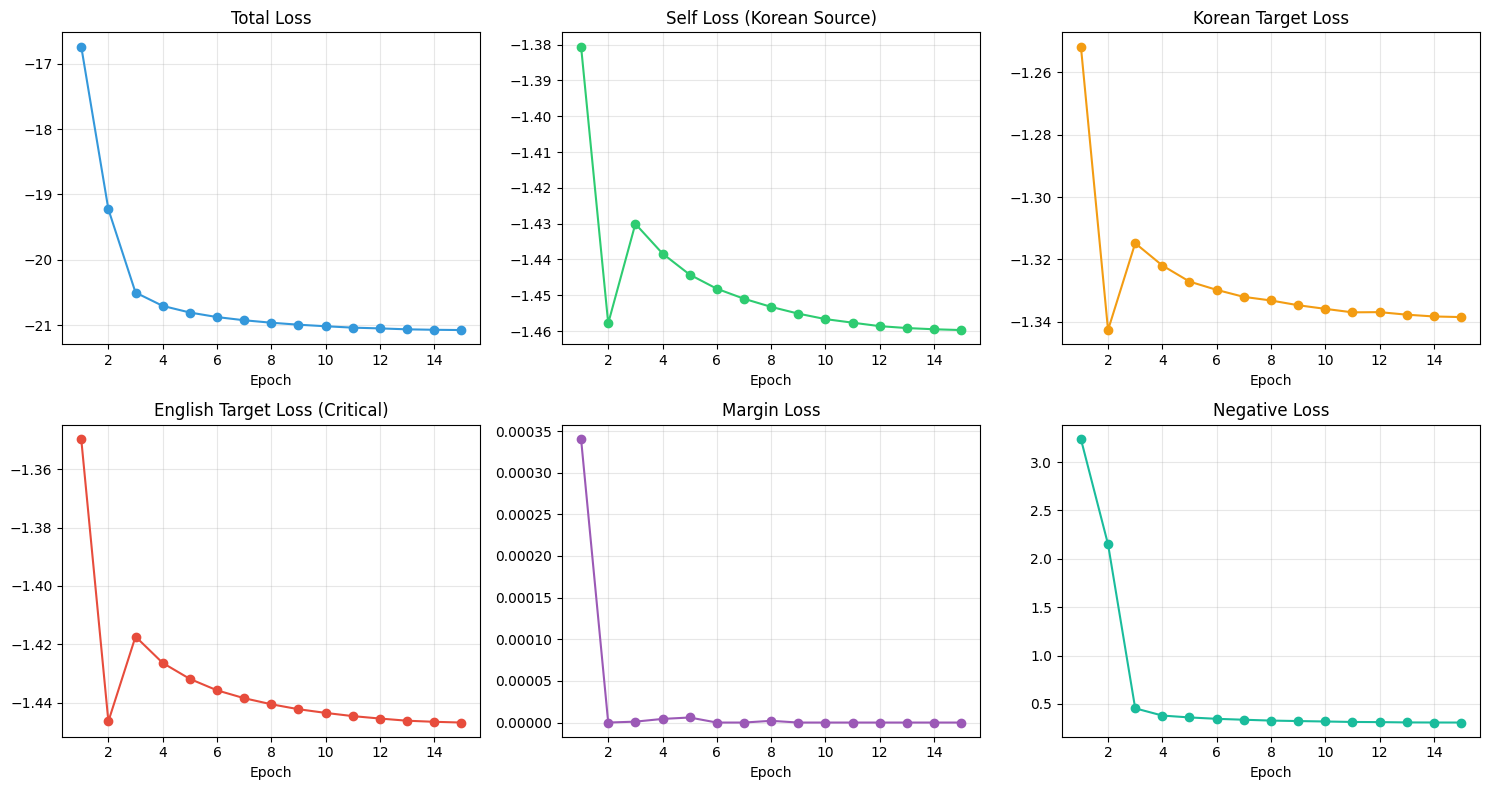

In [17]:
# Plot training curves
if history:
    # Check format
    has_separate_targets = 'ko_target' in history[0]
    
    if has_separate_targets:
        # New format: 2x3 grid with separate Korean/English losses
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        epochs = range(1, len(history) + 1)

        axes[0, 0].plot(epochs, [h['total'] for h in history], '-o', color='#3498db')
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(epochs, [h['self'] for h in history], '-o', color='#2ecc71')
        axes[0, 1].set_title('Self Loss (Korean Source)')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].grid(True, alpha=0.3)

        axes[0, 2].plot(epochs, [h['ko_target'] for h in history], '-o', color='#f39c12')
        axes[0, 2].set_title('Korean Target Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].grid(True, alpha=0.3)

        axes[1, 0].plot(epochs, [h['en_target'] for h in history], '-o', color='#e74c3c')
        axes[1, 0].set_title('English Target Loss (Critical)')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(epochs, [h['margin'] for h in history], '-o', color='#9b59b6')
        axes[1, 1].set_title('Margin Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].grid(True, alpha=0.3)

        axes[1, 2].plot(epochs, [h['negative'] for h in history], '-o', color='#1abc9c')
        axes[1, 2].set_title('Negative Loss')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        # Old format: 2x2 grid
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        epochs = range(1, len(history) + 1)

        axes[0, 0].plot(epochs, [-h['total'] for h in history], '-o', color='#3498db')
        axes[0, 0].set_title('Total Loss (negated)')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(epochs, [-h['self'] for h in history], '-o', color='#2ecc71')
        axes[0, 1].set_title('Self Loss (Korean Preservation)')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(epochs, [-h['target'] for h in history], '-o', color='#e74c3c')
        axes[1, 0].set_title('Target Loss')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(epochs, [h['negative'] for h in history], '-o', color='#9b59b6')
        axes[1, 1].set_title('Negative Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 6. Detailed Analysis of Specific Terms

In [18]:
# Analyze specific terms in detail
print("=" * 80)
print("Detailed Analysis: Sample Terms")
print("=" * 80)

detail_terms = ["추천", "검색", "인공지능", "데이터베이스", "보안"]

for term in detail_terms:
    result = encode_term(term, top_k=15)
    print(f"\n{term}:")
    for i, (token, weight) in enumerate(result["tokens"][:10]):
        print(f"  {i+1:2}. {token:20} {weight:.4f}")

Detailed Analysis: Sample Terms

추천:
   1. 추천                   4.4625
   2. recommended          4.4611
   3. 가이드                  4.4502
   4. 제안                   4.4483
   5. recommendations      4.4374
   6. 파트너                  4.4310
   7. 테스트                  4.4231
   8. 웹사이트                 4.4222
   9. 아이디어                 4.4211
  10. 그룹                   4.4206

검색:
   1. search               4.5154
   2. 서핑                   4.4652
   3. 검색                   4.4486
   4. 웹사이트                 4.4483
   5. 테스트                  4.4441
   6. 계산                   4.4352
   7. 청소                   4.4328
   8. 그룹                   4.4316
   9. 링크                   4.4311
  10. 쇼핑                   4.4305

인공지능:
   1. 인공지능                 4.5650
   2. 로봇                   4.4893
   3. 애플리케이션               4.4560
   4. tech                 4.4253
   5. 스마트폰                 4.4157
   6. 기계                   4.4113
   7. 컴퓨터                  4.4105
   8. 능력                   4.4084

## 7. Dataset Analysis

In [19]:
# Analyze v19 dataset
dataset_path = PROJECT_ROOT / "dataset" / "v19_high_quality" / "term_pairs.jsonl"

if dataset_path.exists():
    data = []
    sources = {}
    
    with open(dataset_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line.strip())
            data.append(item)
            source = item.get("source", "unknown")
            sources[source] = sources.get(source, 0) + 1
    
    print(f"Total pairs: {len(data):,}")
    print(f"\nData sources:")
    for source, count in sorted(sources.items(), key=lambda x: -x[1]):
        print(f"  {source}: {count:,} ({count/len(data)*100:.1f}%)")
    
    print(f"\nSample pairs:")
    for item in data[:10]:
        print(f"  {item['ko']} -> {item['en']} ({item.get('source', 'unknown')})")
else:
    print(f"Dataset not found: {dataset_path}")

Total pairs: 20,594

Data sources:
  muse: 20,455 (99.3%)
  wikidata: 119 (0.6%)
  it_terminology: 20 (0.1%)

Sample pairs:
  분류 -> category (muse)
  분류 -> categorization (muse)
  분류 -> categories (muse)
  분류 -> classification (muse)
  토론 -> discussions (muse)
  토론 -> discussion (muse)
  토론 -> debate (muse)
  토론 -> debates (muse)
  선수 -> players (muse)
  선수 -> player (muse)


## 8. Conclusion

### v19 Results Summary

v19 was trained with the following goals:

1. **Remove wikidata noise** from v18 dataset
2. **Focus on quality** over quantity (~18K vs 33K pairs)
3. **Use same hyperparameters** as successful v17 model

### Key Observations

- Korean preservation rate shows how well the model maintains the input Korean term
- English activation rate shows cross-lingual term expansion capability
- Combined score = Korean rate + English rate

### Next Steps

1. **Analyze data quality**: Investigate what makes certain translation pairs effective
2. **Loss function tuning**: Consider adjusting target loss weight for better English activation
3. **Data filtering**: Apply stricter quality filters to identify high-impact pairs